In [51]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Property Assessment Indicators
- Data is pulled from City of Edmonton Open Data portal.

In [52]:
df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', low_memory=False)

### Drop the City of Edmonton's account number and rename the columns more logically
- `nb` stands for neighbourhood

In [53]:
df.drop('Account Number', axis=1, inplace=True)
df.columns = ['suite', 'number', 'street', 'value', 'class', 'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']

### Remove and verify the number of null records
- This dataset contains one record without a neighbourhood ID.
    - This record has a substantially lower property assessment value.
    - This record represents an outlier in the nearly 400,000 records

In [54]:
df_null = df[df.nb_id.isnull()]

df_clean = df[~df.nb_id.isnull()]
print('number of null records = {}'.format(len(df_null)))

number of null records = 1


# Edmonton Criminal Incidents by Neibourhood
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

In [74]:
df_crim = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', 
                      dtype={'Incident Reported Year':str, 'Incident Reported Month':str})

### Rename the columns more logically and to align with `df_cleaned`

In [75]:
df_crim.columns = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']

### Pivot the table to provide a clean merge and representation of the total number of criminal incidents between 2009-2018 for each of the 8 violation categories

In [76]:
nb_incidents = df_crim_clean.pivot_table(index='nb', values='num_incidents', columns='violation', aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

In [77]:
property_assess = df_clean.merge(nb_incidents, left_on='nb', right_index=True)
property_assess.reset_index(inplace=True)
property_assess.drop('index', axis=1, inplace=True)
property_assess.head(1)

,suite,number,street,value,class,nb_id,nb,ward,garage,lat,long,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000
0,1005,10011.0,123 STREET NW,259000,Residential,1150.0,OLIVER,Ward 6,N,53.540949,-113.533619,1314.0,973.0,8.0,295.0,151.0,1941.0,903.0,43.0


### Assessment of property outliers

Text(0,0.5,'Assessed Value in Trillions (CAD)')

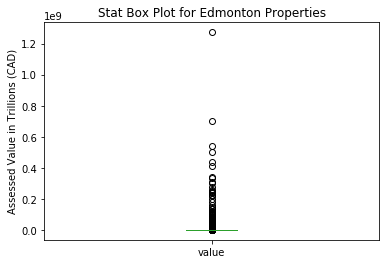

In [63]:
ax = property_assess['value'].plot(kind='box', title='Stat Box Plot for Edmonton Properties')
ax.set_ylabel('Assessed Value in Trillions (CAD)')

Text(0,0.5,'Assessed Value x 10 Billion (CAD)')

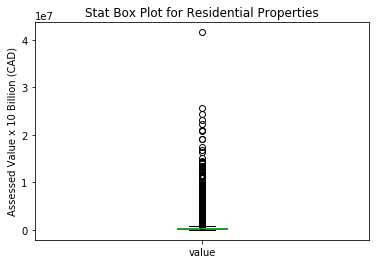

In [66]:
df_res = property_assess[property_assess['class'] == 'Residential']
ax = df_res['value'].plot(kind='box', title='Stat Box Plot for Residential Properties')
ax.set_ylabel('Assessed Value x 10 Billion (CAD)')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


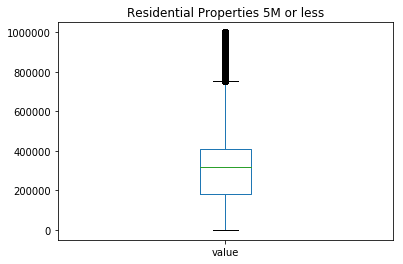

In [73]:
df_norm = df_res[property_assess['value'] <= 1000000]
ax = df_norm['value'].plot(kind='box', title='Residential Properties 5M or less')